In [ ]:
# Integrantes Equipo 1:
# - Juan (Capitán)
# - David
# - Alfonso
# - Irving
# - Raúl
# - Alejandro

In [2]:
# Conjunto de datos: https://www.kaggle.com/datasets/kanchana1990/whatsapp-business-reviews-app-store
#
#
# Diccionario de datos:
#
# ID: Unique identifier for each review entry.
# Date: Timestamp of the review.
# UserName (Hashed): Anonymized username of the reviewer.
# UserUrl (Hashed): Anonymized URL of the user's review profile.
# Version: App version the review pertains to.
# Score: User-provided rating for the app.
# Title: Title of the review.
# Text: Body text of the review, providing detailed feedback.
# URL: URL of the review on the App Store (anonymized if containing personal identifiers).
# Country: The country from which the review was posted.

In [3]:
# Instalación dependencias nltk: vader_lexicon (para análisis de sentimientos) y stopwords (para limpieza de texto)
import nltk
nltk.download("vader_lexicon")
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Exploración de datos, limpieza y creación de variables

In [4]:
# Carga de datos
import pandas as pd
data = pd.read_csv('data/hashed_wab_reviews.csv')

In [5]:
# EDA (Analisis Exploratorio de Datos - Exploratory Data Analysis)

In [6]:
data.dtypes.to_frame()

,0
id,int64
date,object
userName,object
userUrl,object
version,object
score,int64
title,object
text,object
url,object
country,object


In [7]:
data.head(3)

,id,date,userName,userUrl,version,score,title,text,url,country,appId
0,10990027692,2024-02-28T13:15:16-07:00,a71209417cc69068db96287dcfa258e84a19b36c443521...,c6434d50f03dc3225343d08cb75b120e19dc21937007da...,24.4.78,1,Status sounds,No sound comes from status videos after I upda...,https://itunes.apple.com/au/review?id=13864129...,AU,1386412985
1,10939311897,2024-02-14T14:47:02-07:00,9f7302dde70e971b057aa14cec1d26479a9362da32e9ed...,55105d432b1d6c664523f5de2576a199f8ffa8d8c20e8a...,24.3.76,2,Calls,"Every time I’m on a phone call, it either cut ...",https://itunes.apple.com/au/review?id=13864129...,AU,1386412985
2,10932303253,2024-02-12T15:54:56-07:00,ee939200223a21c2bdea5d17ef0ae2d9a03acfbb914c73...,1c044d9599692ebd0d50f4fb8d886f622ee02c549d76f8...,24.3.76,4,Recommendations,I like being to have a separate account/app fo...,https://itunes.apple.com/au/review?id=13864129...,AU,1386412985


In [8]:
df = data.copy()

In [9]:
# Seleccionamos variables que usaremos
df = df[['version', 'score', 'title', 'text', 'country']]

In [10]:
# Missings
df.isnull().sum()

version    0
score      0
title      0
text       0
country    0
dtype: int64

In [11]:
(df.astype(str) == '').sum()

version    0
score      0
title      0
text       0
country    0
dtype: int64

In [12]:
# Las variables que nos serán de utilidad serán:
# Score: 

In [13]:
# Detección de idioma
from langdetect import detect
def detectar(texto):
  try:
    return detect(texto)
  except:
    return "unknown"

df["idioma_title"] = df["title"].apply(detectar)
df["idioma_texto"] = df["text"].apply(detectar)

In [14]:
df[["idioma_title", "idioma_texto"]]

,idioma_title,idioma_texto
0,en,en
1,ca,en
2,fr,en
3,en,en
4,en,en
...,...,...
1454,ar,ar
1455,af,en
1456,ar,ar
1457,es,es


In [15]:
# Reemplazamos todo lo que no sean caracteres ni números por espacios vacíos
df["title"] = (
    df["title"]
    .astype(str)
    .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

df["text"] = (
    df["text"]
    .astype(str)
    .str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
)

In [16]:
# Limpieza de Texto
def limpieza_texto(df, col):
  df[col] = (
      df[col]
      .astype(str)
      .str.replace(r"[\n\r\t]", " ", regex=True) # Quitamos saltos de linea, tabuladores
      .str.replace(":", " ", regex=False) # Se remueve puntuación
      .str.replace(r"\s+", " ", regex=True) # Se remueve signos
      .str.strip() # Se quitan espacios extra
  )
  return df

In [17]:
df = limpieza_texto(df, "title")
df = limpieza_texto(df, "text")

In [18]:
# Removemos emojis
import emoji
def remover_emojis(text):
  if not isinstance(text, str):
    return text
  return emoji.replace_emoji(text, replace="")

In [19]:
df["text"] = df["text"].apply(remover_emojis)
df["title"] = df["title"].apply(remover_emojis)

In [20]:
# Filtramos únicamente títulos y textos en inglés
df = df[(df["idioma_texto"] == "en") & (df["idioma_title"] == "en")]

In [21]:
# Selección de variables objetivo
# Continua: Score - Valores de 1 a 5, se entenderán como variable continua
# Discreta (dicotómica):  Score categórica - 1 si el score tiene valores (4,5); 0 si tiene valores (1,2,3)

In [22]:
df['score_cat'] = (df['score']>=4)*1 # 1  para valores (4,5). 0 para valores (1,2,3)

In [23]:
# Distribución de variable objetivo categórica
df['score_cat'].value_counts() / df.shape[0]

score_cat
0    0.558904
1    0.441096
Name: count, dtype: float64

In [24]:
# Distribución de variable objetivo continua
df['score'].value_counts().sort_index() / df.shape[0]

score
1    0.367123
2    0.082192
3    0.109589
4    0.104110
5    0.336986
Name: count, dtype: float64

In [25]:
# Creación de variables

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [27]:
sia = SentimentIntensityAnalyzer()

In [28]:
# Creación de variables de sentimiento detectado ('Text')
df["text_sentiment_score"] = df["text"].apply(sia.polarity_scores)
df["title_sentiment_score"] = df["title"].apply(sia.polarity_scores)

In [29]:
scores_df = df["text_sentiment_score"].apply(pd.Series)
df = pd.concat([df, scores_df], axis=1)
del df['text_sentiment_score']

In [30]:
df = df.rename(columns={
    "neg":"neg_text",
    "neu":"neu_text",
    "pos":"pos_text",
    "compound":"compound_text"
})

In [31]:
# Categorías positivo, negativo y neutral
df["sentiment_text"] = "neutral"
df.loc[df["compound_text"] > 0.05, "sentiment_text"] = "positive"
df.loc[df["compound_text"] < -0.05, "sentiment_text"] = "negative"

In [32]:
df['sentiment_text'].value_counts()

sentiment_text
positive    354
negative    205
neutral     171
Name: count, dtype: int64

In [33]:
# Creación de variables de sentimiento detectado ('Title')
scores_df = df["title_sentiment_score"].apply(pd.Series)
df = pd.concat([df, scores_df], axis=1)
del df['title_sentiment_score']

In [34]:
df = df.rename(columns={
    "neg":"neg_title",
    "neu":"neu_title",
    "pos":"pos_title",
    "compound":"compound_title"
})

In [35]:
df["sentiment_title"] = "neutral"
df.loc[df["compound_title"] > 0.05,  "sentiment_title"] = "positive"
df.loc[df["compound_title"] < -0.05, "sentiment_title"] = "negative"

In [36]:
# Correlación entre sentimientos de título y texto del review
df[["compound_title","compound_text"]].corr()

,compound_title,compound_text
compound_title,1.000000,0.404144
compound_text,0.404144,1.000000


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

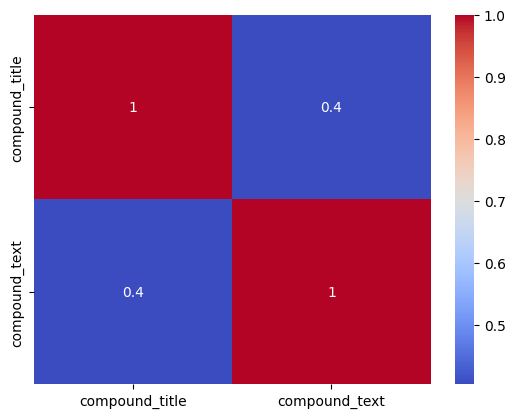

In [38]:
# Relación debil entre título y texto. Los titulos son poco informativos al ser muy cortos
sns.heatmap(
    df[["compound_title","compound_text"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.show()

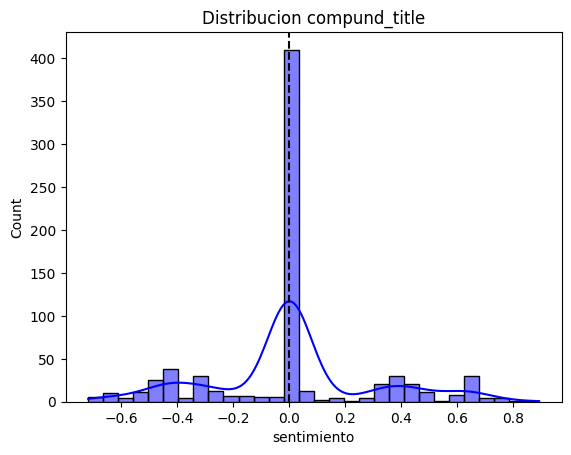

In [39]:
# La distribución del sentimiento del Título muestra una combinación de distribuciones para los valores negativos, otra para los positivos y otra para los neutros (crecanos a 0)
sns.histplot(
    df["compound_title"],
    bins=30,
    kde=True,
    color="blue"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribucion compund_title")
plt.xlabel("sentimiento")
plt.show()

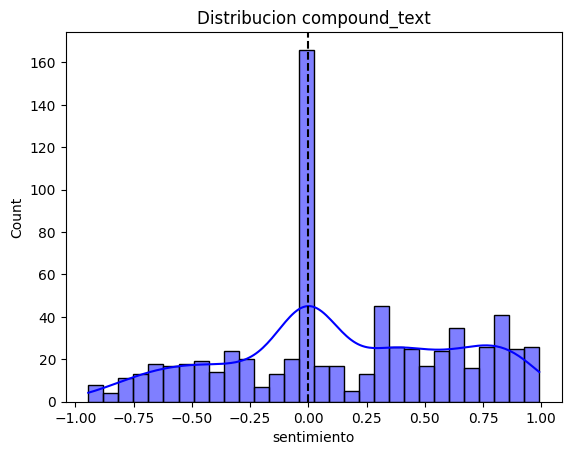

In [40]:
# El texto del review muestra una dsitribución menos cargada hacia el neutro
sns.histplot(
    df["compound_text"],
    bins=30,
    kde=True,
    color="blue"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribucion compound_text")
plt.xlabel("sentimiento")
plt.show()

In [41]:
# Variable de compound promedio
df["compound_avg"] = df[["compound_title","compound_text"]].mean(axis=1)

In [42]:
# El score y el compound tienen una correlación moderada
print("Correlacion entre score y compound_avg", df["score"].corr(df["compound_avg"]))

Correlacion entre score y compound_avg 0.5361636631360516


In [43]:
# Variables unarias
variables_unarias = df.nunique()[df.nunique()==1].index.tolist()
variables_unarias


['idioma_title', 'idioma_texto']

In [44]:
df.drop(columns = variables_unarias, inplace=True)

In [45]:
# Creación de variables dummies
categoricas_dummies = ['country', 'version', 'sentiment_text', 'sentiment_title']

In [46]:
def normalize(df, features):
    for feature in features:
        aux = df[feature].value_counts(True)
        ls_categories = [category for category, freq in aux.items() if freq > 0.05]
        df[feature] = df[feature].map(lambda x: x if x in ls_categories else "Others")
    return df

In [47]:
df = normalize(df, [x for x in categoricas_dummies])

In [48]:
def freq_discrete(df, features):
    """
    Calcula y muestra tablas de frecuencias absolutas, relativas y acumuladas para variables categóricas.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene las variables a analizar.
    features : list of str
        Lista con los nombres de las columnas categóricas a analizar.

    Descripción
    -----------
    Para cada variable en `features`, imprime su nombre y muestra una tabla con:
      - Frecuencia absoluta de cada categoría.
      - Frecuencia relativa (porcentaje) de cada categoría.
      - Frecuencia absoluta acumulada.
      - Frecuencia relativa acumulada.
    Los valores se formatean para mejor visualización.

    Ejemplo
    -------
    freq_discrete(df, ["color", "country"])
    """
    for feature in features:
        print(f"Feature: {feature}")
        abs_series = df[feature].value_counts(dropna=False)
        rel_series = df[feature].value_counts(dropna=False, normalize=True)
        freq = pd.DataFrame({"Absolute frequency": abs_series, "Relative frequency": rel_series})
        freq["Accumulated frequency"] = freq["Absolute frequency"].cumsum()
        freq["Accumulated %"] = freq["Relative frequency"].cumsum()
        freq["Absolute frequency"] = freq["Absolute frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Relative frequency"] = freq["Relative frequency"].map(lambda x: "{:,.2%}".format(x))
        freq["Accumulated frequency"] = freq["Accumulated frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Accumulated %"] = freq["Accumulated %"].map(lambda x: "{:,.2%}".format(x))
        display(freq)

In [49]:
freq_discrete(df, categoricas_dummies)

Feature: country


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
country,,,,
LK,328,44.93%,328,44.93%
US,208,28.49%,536,73.42%
CA,131,17.95%,667,91.37%
AU,63,8.63%,730,100.00%


Feature: version


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
version,,,,
Others,638,87.40%,638,87.40%
23.25.86,52,7.12%,690,94.52%
23.23.82,40,5.48%,730,100.00%


Feature: sentiment_text


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
sentiment_text,,,,
positive,354,48.49%,354,48.49%
negative,205,28.08%,559,76.58%
neutral,171,23.42%,730,100.00%


Feature: sentiment_title


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
sentiment_title,,,,
neutral,410,56.16%,410,56.16%
negative,164,22.47%,574,78.63%
positive,156,21.37%,730,100.00%


In [50]:
df_dummies = pd.get_dummies(df[categoricas_dummies], drop_first=True).astype(int)

In [51]:
df = df.drop(columns=categoricas_dummies).join(df_dummies)

In [52]:
df.columns

Index(['score', 'title', 'text', 'score_cat', 'neg_text', 'neu_text',
       'pos_text', 'compound_text', 'neg_title', 'neu_title', 'pos_title',
       'compound_title', 'compound_avg', 'country_CA', 'country_LK',
       'country_US', 'version_23.25.86', 'version_Others',
       'sentiment_text_neutral', 'sentiment_text_positive',
       'sentiment_title_neutral', 'sentiment_title_positive'],
      dtype='object')

In [53]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Descarga datos de NLTK
nltk.download('punkt_tab') # modelo Punkt para separar texto en palabras (tokenizador). Nrcesario para word_tokenize()
nltk.download('wordnet') # Para lematización. Necesario para WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger') # Mejorar lematización, categorizando palabras en Verbos, Sustantivos, Adjetivos, etc.

stop_words_en = set(stopwords.words('english'))


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
def procesar_texto(texto):
    # Convierte textoo a minúsculas
    texto = texto.lower()
    
    # Tokenizador (separar en palabras)
    tokens = word_tokenize(texto)
    
    # Remover puntuación
    tokens = [word for word in tokens if word.isalpha()]
    
    # Remover stopwords
    tokens = [word for word in tokens if word not in stop_words_en]
    
    # Lemmatización (quitar conjugación)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]  # verbos
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]  # sustantivos
    
    return tokens

In [55]:
df['text_procesado'] = df['text'].apply(lambda x: ' '.join(procesar_texto(x)))

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

In [57]:
vectorizer = CountVectorizer(
    max_features=int(df.shape[0]/2),
    min_df=5,
    max_df=0.7
)
word_counts = vectorizer.fit_transform(df['text_procesado']) 

In [58]:
df_words = pd.DataFrame(
    word_counts.toarray(), 
    columns=vectorizer.get_feature_names_out()
)

In [59]:
df_words.head(3)

,ability,able,access,account,active,activity,actually,add,allow,already,...,work,world,would,write,wrong,wtf,year,yes,yesterday,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df.shape

(730, 23)

In [61]:
df_words.shape

(730, 365)

In [62]:
df = pd.concat([df.reset_index(drop=True), df_words.reset_index(drop=True)], axis=1)

In [63]:
# Selección de variables
target_cat = 'score_cat'
target_cont = 'score'

features = [c for c in df.columns if c not in [target_cat, target_cont, 'text', 'title', 'text_procesado']]
df[features].dtypes.value_counts()

int64      373
float64      9
Name: count, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split

# 2. Variable objetivo Categórica

In [65]:
# Selección de conjuntos de entrenamiento para variable objetivo categórica
cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(
    df[features], df[target_cat], test_size=0.2, random_state=42
)

In [66]:
# Guardamos conjuntos de datos
cat_X_train.to_csv('cat_X_train.csv', encoding='utf8')
cat_X_test.to_csv('cat_X_test.csv', encoding='utf8')
cat_y_train.to_csv('cat_y_train.csv', encoding='utf8')
cat_y_test.to_csv('cat_y_test.csv', encoding='utf8')

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

In [69]:
metrica = 'roc_auc'
X = cat_X_train 
y = cat_y_train

# Escaladores de datos para pipelines
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Modelos
models = {
    'LogisticRegression': (LogisticRegression(), {
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear'],
        'model__max_iter': [100, 200, 500]
    }),
}

# Tabla de resultados con mejores modelos
results = []
best = {'score': float('-inf'), 'entry': None}


for scaler_name, scaler in scalers.items():
    for model_name, (model, param_grid) in models.items():
        # Creación de nuevo pipeline con esaclamiento antes del modelo
        pipe = Pipeline([('scaler', scaler), ('model', model)])

        # Hiperparametrización
        search = GridSearchCV(pipe, param_grid, cv=4, scoring=metrica, n_jobs=-1, error_score='raise', verbose=True)
        search.fit(X,y.values.ravel())
        
        # Resultado de hiperparametrización
        score = search.best_score_
        row = {
            'scaler': scaler_name,
            'model': model_name,
            'best_params': search.best_params_,
            'best_score': score,
            'best_estimator': search.best_estimator_
        }
        results.append(row)

        # Revisa si el nuevo modelo es mejor que los anteriores
        if score > best['score']:
            best = {'score': score, 'entry': row}


results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='best_score', ascending=False).reset_index(drop=True)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits


In [70]:
results_df

,scaler,model,best_params,best_score,best_estimator
0,RobustScaler,LogisticRegression,"{'model__max_iter': 100, 'model__penalty': 'l2...",0.900760,"(RobustScaler(), LogisticRegression(solver='li..."
1,MinMaxScaler,LogisticRegression,"{'model__max_iter': 100, 'model__penalty': 'l2...",0.898101,"(MinMaxScaler(), LogisticRegression(solver='li..."
2,StandardScaler,LogisticRegression,"{'model__max_iter': 200, 'model__penalty': 'l1...",0.881719,"(StandardScaler(), LogisticRegression(max_iter..."


In [71]:
# Guardado de resultados (en pickle para tener los modelos entrenados disponibles sin necesidad de entrenarlos de nuevo)
results_df.to_pickle('categorica_resultados_todos_modelos.pk')

# Guardamos el mejor de todos en un objeto en particular
if best['entry'] is not None:
    pd.to_pickle(best['entry']['best_estimator'], 'categorica_mejor_modelos.pk')

best_summary = pd.DataFrame([best['entry']])
best_summary.head()

,scaler,model,best_params,best_score,best_estimator
0,RobustScaler,LogisticRegression,"{'model__max_iter': 100, 'model__penalty': 'l2...",0.90076,"(RobustScaler(), LogisticRegression(solver='li..."


In [72]:
mejor_modelo = best['entry']['best_estimator']

In [73]:
cat_y_hat_test = mejor_modelo.predict(cat_X_test)

In [74]:
from sklearn.metrics import roc_auc_score

In [75]:
# Validamos en conjunto de Test
roc_auc_score(cat_y_test, mejor_modelo.predict_proba(cat_X_test)[:, 1])

0.90284178187404

In [76]:
# interpretación de modelo
p = f'''
Modelo: {best['entry']['model']}
Escalador: {best['entry']['scaler']}
'''

print(p)



Modelo: LogisticRegression
Escalador: RobustScaler



In [77]:
mejor_modelo['model'].intercept_

array([-0.5539734])

In [78]:
coef_df = pd.DataFrame({
    'Feature': cat_X_test.columns,
    'Coefficient (Beta)': mejor_modelo['model'].coef_[0]
}).sort_values('Coefficient (Beta)')

In [79]:
columnas_numericas = cat_X_train.columns[:18]
columnas_palabras = cat_X_train.columns[18:]

In [80]:
# La presencia de algunas palabras ayuda a determinar si la calificación (score) aumenta

# Palabras con métricas de sentimientos y país
coef_df[coef_df['Feature'].isin(columnas_numericas)]


# Los sentimientos generados con el modelo SentimentIntensityAnalyzer ayudan a determinar si la calificación aumenta o disminuye.
# Negativas:
# - el sentimiento neutro para el título
# - el sentimiento negativo para el texto de review
# Positivas:
# - El sentimiento positivo en texto de review
# - El compund promedio entre Título y texto de review

,Feature,Coefficient (Beta)
17,sentiment_title_positive,-0.382426
7,compound_title,-0.292459
12,version_23.25.86,-0.169741
1,neu_text,-0.155338
11,country_US,-0.139486
0,neg_text,-0.056084
2,pos_text,-0.027992
5,neu_title,-0.019716
4,neg_title,-0.015482
9,country_CA,0.069164


In [ ]:
# Palabras con métricas de sentimientos y país
coef_df[coef_df['Feature'].isin(columnas_palabras)]

# Algunas palabras aportan en la calificación predicha
# Negativas:
# - limit
# - code
# - fix
# - get
# - delete
# Positivas:
# - touch
# - thats
# - morning
# - color
# - click
# Para las cuales se puede hacer una exploración más detallada

,Feature,Coefficient (Beta)
126,fix,-1.406003
177,limit,-1.369954
131,get,-1.341512
93,delete,-1.073814
73,code,-1.033040
...,...,...
74,color,1.121573
70,click,1.153868
46,back,1.155701
324,thats,1.197319


# 3. Variable objetivo Continua

In [82]:
# Selección de conjuntos de entrenamiento para variable objetivo categórica
cont_X_train, cont_X_test, cont_y_train, cont_y_test = train_test_split(
    df[features], df[target_cont], test_size=0.2, random_state=42
)

In [83]:
# Guardamos conjuntos de datos
cont_X_train.to_csv('cont_X_train.csv', encoding='utf8')
cont_X_test.to_csv('cont_X_test.csv', encoding='utf8')
cont_y_train.to_csv('cont_y_train.csv', encoding='utf8')
cont_y_test.to_csv('cont_y_test.csv', encoding='utf8')

In [84]:
from sklearn.linear_model import LinearRegression, Lars, Lasso, Ridge, ElasticNet, BayesianRidge, SGDRegressor
import numpy as np

In [85]:
from datetime import datetime

In [86]:
(datetime.now() - datetime.now()).total_seconds()

0.0

In [87]:
metrica = 'r2'
X = cont_X_train.copy()
y = cont_y_train.copy()

# Escaladores de datos para pipelines
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Modelos
models = {
    'LinearRegression': (LinearRegression(), {
        'model__fit_intercept': [True, False]
    }),
    'Lars': (Lars(), {
        'model__n_nonzero_coefs': [1, 2, 3, 4, 5, 6, 8, 10, 12, 15]
    }),
    'Ridge': (Ridge(), {
        'model__alpha': np.logspace(-4, 4, 20),
        'model__tol': [1e-5, 1e-4, 1e-3],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
    }),
    'Lasso': (Lasso(), {
        'model__alpha': np.logspace(-4, 3, 20),
        'model__tol': [1e-5, 1e-4, 1e-3],
        'model__selection': ['cyclic', 'random']
    }),
    'ElasticNet': (ElasticNet(), {
        'model__alpha': np.logspace(-4, 3, 20),
        'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'model__selection': ['cyclic', 'random']
    }),
    'BayesianRidge': (BayesianRidge(), {
        'model__tol': [1e-3, 1e-5],
        'model__alpha_1': [1e-6, 1e-8],
        'model__alpha_2': [1e-6, 1e-8],
        'model__lambda_1': [1e-6, 1e-8],
        'model__lambda_2': [1e-6, 1e-8],
        'model__alpha_init': [None, 1.0, 0.1],
        'model__lambda_init': [None, 1.0, 0.1],
        'model__fit_intercept': [True, False],
        'model__compute_score': [True, False]
    }),
    'SGDRegressor': (SGDRegressor(), {
        'model__loss': ['squared_error'],
        'model__penalty': ['l2', 'l1', 'elasticnet'],
        'model__alpha': [0.0001, 0.001, 0.01],
        'model__l1_ratio': [0.15, 0.5, 0.75],
        'model__fit_intercept': [True, False],
        'model__max_iter': [1000, 5000],
        'model__tol': [1e-3, 1e-4],
        'model__learning_rate': ['constant', 'optimal', 'invscaling'],
        'model__eta0': [0.01, 0.1]
    }),
}

# Tabla de resultados con mejores modelos
cont_results = []
cont_best = {'score': float('-inf'), 'entry': None}


for scaler_name, scaler in scalers.items():
    for model_name, (model, param_grid) in models.items():
        start = datetime.now()
        print(f'Entrenando modelo [{model_name}] con escalador [{scaler_name}]',)

        # Creación de nuevo pipeline con esaclamiento antes del modelo
        pipe = Pipeline([('scaler', scaler), ('model', model)])

        # Hiperparametrización
        search = GridSearchCV(pipe, param_grid, cv=4, scoring=metrica, n_jobs=-1, error_score='raise', verbose=True)
        search.fit(X, y.values.ravel())
        
        # Resultado de hiperparametrización
        score = search.best_score_
        row = {
            'scaler': scaler_name,
            'model': model_name,
            'best_params': search.best_params_,
            'best_score': score,
            'best_estimator': search.best_estimator_
        }
        cont_results.append(row)

        # Revisa si el nuevo modelo es mejor que los anteriores
        if score > cont_best['score']:
            cont_best = {'score': score, 'entry': row}

        total_time = (datetime.now() - start).total_seconds()
        print(f' Tiempo total en segundos: {round(total_time,2)}')
cont_results_df = pd.DataFrame(cont_results)
cont_results_df = cont_results_df.sort_values(by='best_score', ascending=False).reset_index(drop=True)

Entrenando modelo [LinearRegression] con escalador [StandardScaler]
Fitting 4 folds for each of 2 candidates, totalling 8 fits
 Tiempo total en segundos: 0.4
Entrenando modelo [Lars] con escalador [StandardScaler]
Fitting 4 folds for each of 10 candidates, totalling 40 fits
 Tiempo total en segundos: 0.48
Entrenando modelo [Ridge] con escalador [StandardScaler]
Fitting 4 folds for each of 300 candidates, totalling 1200 fits
 Tiempo total en segundos: 38.78
Entrenando modelo [Lasso] con escalador [StandardScaler]
Fitting 4 folds for each of 120 candidates, totalling 480 fits
 Tiempo total en segundos: 6.09
Entrenando modelo [ElasticNet] con escalador [StandardScaler]
Fitting 4 folds for each of 200 candidates, totalling 800 fits
 Tiempo total en segundos: 9.99
Entrenando modelo [BayesianRidge] con escalador [StandardScaler]
Fitting 4 folds for each of 1152 candidates, totalling 4608 fits
 Tiempo total en segundos: 161.62
Entrenando modelo [SGDRegressor] con escalador [StandardScaler]
Fi

In [88]:
cont_results_df = pd.DataFrame(cont_results)
cont_results_df = cont_results_df.sort_values(by='best_score', ascending=False).reset_index(drop=True)
cont_results_df

,scaler,model,best_params,best_score,best_estimator
0,StandardScaler,ElasticNet,"{'model__alpha': 0.2069138081114788, 'model__l...",4.858661e-01,"(StandardScaler(), ElasticNet(alpha=np.float64..."
1,StandardScaler,Lasso,"{'model__alpha': 0.0379269019073225, 'model__s...",4.779246e-01,"(StandardScaler(), Lasso(alpha=np.float64(0.03..."
2,StandardScaler,BayesianRidge,"{'model__alpha_1': 1e-08, 'model__alpha_2': 1e...",4.757382e-01,"(StandardScaler(), BayesianRidge(alpha_1=1e-08..."
3,StandardScaler,Ridge,"{'model__alpha': 545.5594781168514, 'model__so...",4.756920e-01,"(StandardScaler(), Ridge(alpha=np.float64(545...."
4,MinMaxScaler,SGDRegressor,"{'model__alpha': 0.01, 'model__eta0': 0.01, 'm...",4.637581e-01,"(MinMaxScaler(), SGDRegressor(alpha=0.01, lear..."
5,MinMaxScaler,BayesianRidge,"{'model__alpha_1': 1e-06, 'model__alpha_2': 1e...",4.626965e-01,"(MinMaxScaler(), BayesianRidge(alpha_2=1e-08, ..."
6,MinMaxScaler,Ridge,"{'model__alpha': 4.281332398719396, 'model__so...",4.615780e-01,"(MinMaxScaler(), Ridge(alpha=np.float64(4.2813..."
7,MinMaxScaler,ElasticNet,"{'model__alpha': 0.0069519279617756054, 'model...",4.598369e-01,"(MinMaxScaler(), ElasticNet(alpha=np.float64(0..."
8,RobustScaler,ElasticNet,"{'model__alpha': 0.01623776739188721, 'model__...",4.532677e-01,"(RobustScaler(), ElasticNet(alpha=np.float64(0..."
9,RobustScaler,Ridge,"{'model__alpha': 11.288378916846883, 'model__s...",4.503601e-01,"(RobustScaler(), Ridge(alpha=np.float64(11.288..."


In [89]:
# Guardado de resultados (en pickle para tener los modelos entrenados disponibles sin necesidad de entrenarlos de nuevo)
cont_results_df.to_pickle('continua_resultados_todos_modelos.pk')

# Guardamos el mejor de todos en un objeto en particular
if cont_best['entry'] is not None:
    pd.to_pickle(cont_best['entry']['best_estimator'], 'continua_mejor_modelos.pk')

best_summary = pd.DataFrame([cont_best['entry']])
best_summary.head()

,scaler,model,best_params,best_score,best_estimator
0,StandardScaler,ElasticNet,"{'model__alpha': 0.2069138081114788, 'model__l...",0.485866,"(StandardScaler(), ElasticNet(alpha=np.float64..."


In [90]:
cont_mejor_modelo = cont_best['entry']['best_estimator']

In [91]:
from sklearn.metrics import r2_score

In [92]:
# Validamos en conjunto de Test
r2_score(cont_y_test, cont_mejor_modelo.predict(cont_X_test))

0.4082116264250456

In [93]:
# interpretación de modelo
p = f'''
Modelo: {cont_best['entry']['model']}
Escalador: {cont_best['entry']['scaler']}
'''
print(p)


Modelo: ElasticNet
Escalador: StandardScaler



In [94]:
cont_coef_df = pd.DataFrame({
    'Feature': cont_X_test.columns,
    'Coefficient (Beta)': cont_mejor_modelo['model'].coef_
}).sort_values('Coefficient (Beta)')

In [95]:
columnas_numericas = cont_X_train.columns[:18]
columnas_palabras = cont_X_train.columns[18:]

In [96]:
# La presencia de algunas palabras ayuda a determinar si la calificación (score) aumenta

# Palabras con métricas de sentimientos y país
cont_coef_df[cont_coef_df['Feature'].isin(columnas_numericas)]


# Los sentimientos generados con el modelo SentimentIntensityAnalyzer ayudan a determinar si la calificación aumenta o disminuye.
# Negativas:
# - el sentimiento negativo para el texto de review
# Positivas:
# - El compund promedio entre Título y texto de review
# - El sentimiento positivo en título
# - El sentimiento positivo en texto de review
# - El compund del título

,Feature,Coefficient (Beta)
0,neg_text,-0.089497
14,sentiment_text_neutral,-0.028729
1,neu_text,-0.013310
12,version_23.25.86,-0.011197
4,neg_title,-0.008337
11,country_US,-0.006997
5,neu_title,-0.003175
9,country_CA,0.000000
16,sentiment_title_neutral,-0.000000
13,version_Others,0.000000


In [97]:
# Palabras con métricas de sentimientos y país
cont_coef_df[cont_coef_df['Feature'].isin(columnas_palabras)]

# Algunas palabras aportan en la calificación predicha
# Negativas:
# - fix
# - cant
# - get
# - support
# - new
# Positivas:
# - touch
# - place
# - matter
# - morning
# - need
# Para las cuales se puede hacer una exploración más detallada

,Feature,Coefficient (Beta)
126,fix,-0.195782
315,support,-0.115496
131,get,-0.115008
29,always,-0.109701
150,huge,-0.103792
...,...,...
202,morning,0.094260
191,matter,0.101054
235,place,0.102296
70,click,0.121110


# 4. Notas adicionales

In [98]:
# Se encontraron muchas palabras que no aportan información a los modelos, por lo que se podrían omitir para tener un modelo más ligero